In [1]:
import os, glob
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import scvi

/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def standardize_one_minimal(adata,species = "human",use_ensembl=False):
    if 'gene_symbol_raw' not in adata.var.columns:
        adata.var['gene_symbol_raw'] = adata.var_names.astype(str)
    has_ens_col = "gene_ids" in adata.var.columns
    if use_ensembl and has_ens_col:
        ens = adata.var["gene_ids"].astype(str).str.replace(r"\.\d+$", "", regex=True)
        adata.var_names = ens.values
        adata.var["gene_symbol"] = (
        adata.var["gene_symbol_raw"].astype(str).replace(r"\.\d+$", "",regex=True)
        )
    else:
        adata.var_names = adata.var_names.astype(str).str.replace(r"\.\d+$", "", regex=True)
        adata.var["gene_symbol"] = adata.var_names.astype(str)
        
    adata.var_names_make_unique()
    gs_upper = adata.var["gene_symbol"].astype(str).str.upper()
    adata.var["mt"] = gs_upper.str.startswith("MT-")
    return adata
    

# per-sample QC

In [6]:
def qc_one_sample(adata,min_genes = 200, max_genes = 2500,min_counts = 500,max_pct_mt = 20):
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'],percent_top = None,inplace=True)
    thr = max_pct_mt * 100 if max_pct_mt <= 1 else max_pct_mt
    keep = (
        (adata.obs["n_genes_by_counts"] >= min_genes) & 
        (adata.obs["n_genes_by_counts"]<= max_genes) &
        (adata.obs["total_counts"] >= min_counts) & 
        (adata.obs["pct_counts_mt"] <= thr) 
    )

    adata = adata[keep].copy()
    if "counts" not in adata.layers:
        adata.layers["counts"] = adata.X.copy()
    return adata

In [7]:
try:
    _ = adata_all
except NameError:
    base_dir = '/home/qian@vitra.bio/ava/data/GSE118127'
    patterns = ["**/*filtered_gene_bc_matrices_h5.h5","*filtered_gene_bc_matrices_h5.h5"]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(base_dir,pat),recursive=True))
    files = sorted(set(files))
    assert len(files)>0, f"there is no 10x h5 in {base_dir}. Please check file path or file patterns."
    adatas = []
    for fp in files:
        ad = sc.read_10x_h5(fp)
        sample_name = os.path.basename(fp).replace("_filtered_gene_bc_matrices_h5.h5","")
        ad = standardize_one_minimal(ad,species = "human", use_ensembl = False)
        ad.obs["sample"] = sample_name
        
        raw_shape = ad.shape
        print(f"[{sample_name}] raw shape: cells={raw_shape[0]},genes = {raw_shape[1]}")
        
        ad = qc_one_sample(ad, min_genes=200, min_counts=500, max_pct_mt=20)
        
        qc_shape = ad.shape
        kept_ratio = qc_shape[0] / raw_shape[0] if raw_shape[0] > 0 else 0
        print(f"[{sample_name}] post-QC shape: cells={qc_shape[0]}"
             f"({kept_ratio:.1%} kept),genes = {qc_shape[1]}")
        
        adatas.append(ad)
    
    adata_all = sc.concat(adatas,axis  = 0,join = "outer")
    if "counts" not in adata_all.layers:
        adata_all.layers["counts"] = adata_all.X.copy()
    print(adata_all.shape)
    print(adata_all.obs["sample"].value_counts())

/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319032_sample_1-1] raw shape: cells=5448,genes = 33694
[GSM3319032_sample_1-1] post-QC shape: cells=5442(99.9% kept),genes = 33694
[GSM3319033_sample_1-2] raw shape: cells=1713,genes = 33694
[GSM3319033_sample_1-2] post-QC shape: cells=1695(98.9% kept),genes = 33694
[GSM3319034_sample_1-3] raw shape: cells=3604,genes = 33694
[GSM3319034_sample_1-3] post-QC shape: cells=3593(99.7% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319035_sample_1-4] raw shape: cells=2954,genes = 33694
[GSM3319035_sample_1-4] post-QC shape: cells=2912(98.6% kept),genes = 33694
[GSM3319036_sample_1-5] raw shape: cells=2566,genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319036_sample_1-5] post-QC shape: cells=2389(93.1% kept),genes = 33694
[GSM3319037_sample_1-6] raw shape: cells=2091,genes = 33694
[GSM3319037_sample_1-6] post-QC shape: cells=2074(99.2% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319038_sample_1-7] raw shape: cells=4357,genes = 33694
[GSM3319038_sample_1-7] post-QC shape: cells=4353(99.9% kept),genes = 33694
[GSM3319039_sample_1-8] raw shape: cells=2703,genes = 33694
[GSM3319039_sample_1-8] post-QC shape: cells=2628(97.2% kept),genes = 33694
[GSM3319040_sample_3-13] raw shape: cells=515,genes = 33694
[GSM3319040_sample_3-13] post-QC shape: cells=505(98.1% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319041_sample_3-14] raw shape: cells=1287,genes = 33694
[GSM3319041_sample_3-14] post-QC shape: cells=1273(98.9% kept),genes = 33694
[GSM3319042_sample_3-15] raw shape: cells=820,genes = 33694
[GSM3319042_sample_3-15] post-QC shape: cells=735(89.6% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319043_sample_3-16] raw shape: cells=5135,genes = 33694
[GSM3319043_sample_3-16] post-QC shape: cells=4658(90.7% kept),genes = 33694
[GSM3319044_sample_3-17] raw shape: cells=4541,genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319044_sample_3-17] post-QC shape: cells=3857(84.9% kept),genes = 33694
[GSM3319045_sample_3-18] raw shape: cells=5963,genes = 33694
[GSM3319045_sample_3-18] post-QC shape: cells=4678(78.5% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319046_sample_3-5] raw shape: cells=563,genes = 33694
[GSM3319046_sample_3-5] post-QC shape: cells=485(86.1% kept),genes = 33694
[GSM3319047_sample_3-6] raw shape: cells=166,genes = 33694
[GSM3319047_sample_3-6] post-QC shape: cells=89(53.6% kept),genes = 33694
[GSM3557959_sample1_B1_i12A] raw shape: cells=881,genes = 33694
[GSM3557959_sample1_B1_i12A] post-QC shape: cells=759(86.2% kept),genes = 33694
[GSM3557960_sample10_B2_i10D] raw shape: cells=512,genes = 33694
[GSM3557960_sample10_B2_i10D] post-QC shape: cells=329(64.3% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557961_sample11_B2_i10F] raw shape: cells=1226,genes = 33694
[GSM3557961_sample11_B2_i10F] post-QC shape: cells=1104(90.0% kept),genes = 33694
[GSM3557962_sample12_B2_i10G] raw shape: cells=845,genes = 33694
[GSM3557962_sample12_B2_i10G] post-QC shape: cells=757(89.6% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557963_sample13_B1_i12C] raw shape: cells=435,genes = 33694
[GSM3557963_sample13_B1_i12C] post-QC shape: cells=427(98.2% kept),genes = 33694
[GSM3557964_sample145_B1_i12D] raw shape: cells=1186,genes = 33694
[GSM3557964_sample145_B1_i12D] post-QC shape: cells=1160(97.8% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557965_sample2_B1_i12B] raw shape: cells=739,genes = 33694
[GSM3557965_sample2_B1_i12B] post-QC shape: cells=715(96.8% kept),genes = 33694
[GSM3557966_sample3_B1_i12G] raw shape: cells=108,genes = 33694
[GSM3557966_sample3_B1_i12G] post-QC shape: cells=96(88.9% kept),genes = 33694
[GSM3557967_sample4_B1_i12F] raw shape: cells=555,genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557967_sample4_B1_i12F] post-QC shape: cells=348(62.7% kept),genes = 33694
[GSM3557968_sample5_B2_i10E] raw shape: cells=492,genes = 33694
[GSM3557968_sample5_B2_i10E] post-QC shape: cells=450(91.5% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557969_sample6a_B1_i12H] raw shape: cells=2549,genes = 33694
[GSM3557969_sample6a_B1_i12H] post-QC shape: cells=2514(98.6% kept),genes = 33694
[GSM3557970_sample7_B2_i10C] raw shape: cells=722,genes = 33694
[GSM3557970_sample7_B2_i10C] post-QC shape: cells=610(84.5% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557971_sample8a_B2_i10A] raw shape: cells=529,genes = 33694
[GSM3557971_sample8a_B2_i10A] post-QC shape: cells=446(84.3% kept),genes = 33694
[GSM3557972_sample8b_B2_i10B] raw shape: cells=760,genes = 33694
[GSM3557972_sample8b_B2_i10B] post-QC shape: cells=696(91.6% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557973_sampleC1_B1_i12E] raw shape: cells=241,genes = 33694
[GSM3557973_sampleC1_B1_i12E] post-QC shape: cells=159(66.0% kept),genes = 33694
(51936, 33694)
sample
GSM3319032_sample_1-1           5442
GSM3319045_sample_3-18          4678
GSM3319043_sample_3-16          4658
GSM3319038_sample_1-7           4353
GSM3319044_sample_3-17          3857
GSM3319034_sample_1-3           3593
GSM3319035_sample_1-4           2912
GSM3319039_sample_1-8           2628
GSM3557969_sample6a_B1_i12H     2514
GSM3319036_sample_1-5           2389
GSM3319037_sample_1-6           2074
GSM3319033_sample_1-2           1695
GSM3319041_sample_3-14          1273
GSM3557964_sample145_B1_i12D    1160
GSM3557961_sample11_B2_i10F     1104
GSM3557959_sample1_B1_i12A       759
GSM3557962_sample12_B2_i10G      757
GSM3319042_sample_3-15           735
GSM3557965_sample2_B1_i12B       715
GSM3557972_sample8b_B2_i10B      696
GSM3557970_sample7_B2_i10C       610
GSM3319040_sample_3-13           505
GSM3319046_sample_

/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
adata_all.obs

sample  n_genes_by_counts  \
AAACCTGAGACGCTTT-1        GSM3319032_sample_1-1                937   
AAACCTGAGGCTAGGT-1        GSM3319032_sample_1-1                547   
AAACCTGCAAGTCTGT-1        GSM3319032_sample_1-1               1130   
AAACCTGCAGCTTAAC-1        GSM3319032_sample_1-1                845   
AAACCTGCATTCACTT-1        GSM3319032_sample_1-1                585   
...                                         ...                ...   
TTCGAAGGTATGCTTG-1  GSM3557973_sampleC1_B1_i12E                689   
TTGACTTCATAGGATA-1  GSM3557973_sampleC1_B1_i12E                854   
TTGCGTCCAACAACCT-1  GSM3557973_sampleC1_B1_i12E               2479   
TTGGAACTCGGCTACG-1  GSM3557973_sampleC1_B1_i12E               1576   
TTTACTGCACCGGAAA-1  GSM3557973_sampleC1_B1_i12E               2142   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACCTGAGACGCTTT-1                 6.843750        3230.0            8.080547   
AAACCTGAGGCTAGGT-1                 6.306275        1545.0            7.343426   
AAACCTGCAAGTCTGT-1                 7.030857        2932.0            7.983781   
AAACCTGCAGCTTAAC-1                 6.740519        1673.0            7.422971   
AAACCTGCATTCACTT-1                 6.373320        1363.0            7.218177   
...                                     ...           ...                 ...   
TTCGAAGGTATGCTTG-1                 6.536692        1045.0            6.952729   
TTGACTTCATAGGATA-1                 6.751101        1358.0            7.214504   
TTGCGTCCAACAACCT-1                 7.816014        7093.0            8.867004   
TTGGAACTCGGCTACG-1                 7.363280        3594.0            8.187300   
TTTACTGCACCGGAAA-1                 7.669962        5930.0            8.687948   

                    total_counts_mt  log1p_total_counts_mt  pct_counts_mt  
AAACCTGAGACGCTTT-1             79.0               4.382027       2.445820  
AAACCTGAGGCTAGGT-1             20.0               3.044523       1.294498  
AAACCTGCAAGTCTGT-1             82.0               4.418840       2.796726  
AAACCTGCAGCTTAAC-1             29.0               3.401197       1.733413  
AAACCTGCATTCACTT-1             66.0               4.204693       4.842260  
...                             ...                    ...            ...  
TTCGAAGGTATGCTTG-1             83.0               4.430817       7.942584  
TTGACTTCATAGGATA-1             69.0               4.248495       5.081001  
TTGCGTCCAACAACCT-1            173.0               5.159055       2.439024  
TTGGAACTCGGCTACG-1            116.0               4.762174       3.227602  
TTTACTGCACCGGAAA-1            338.0               5.826000       5.699831  

[51936 rows x 8 columns]

# QC

In [9]:
sc.pp.filter_genes(adata_all,min_cells = 10)
adata_all

/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 51936 × 19635
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_cells'
    layers: 'counts'

# Preprocessing

In [10]:
# HVG
sc.pp.highly_variable_genes(adata_all,flavor = "seurat_v3",n_top_genes=3000,subset=False)
adata_scvi = adata_all[:,adata_all.var["highly_variable"].values].copy()

/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
scvi.model.SCVI.setup_anndata(
    adata_scvi,
    layer="counts" if "counts" in adata_scvi.layers else None,
    batch_key = "sample",
)

In [12]:
model = scvi.model.SCVI(
adata_scvi,
    n_latent = 30,
    gene_likelihood='nb'
)

In [13]:
model.train(
    max_epochs=120,
    early_stopping = True,
    early_stopping_patience=20,
    plan_kwargs={"lr":1e-3},
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40S') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' doe

Epoch 120/120: 100%|██████████| 120/120 [05:10<00:00,  2.65s/it, v_num=1, train_loss_step=575, train_loss_epoch=535]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 120/120: 100%|██████████| 120/120 [05:10<00:00,  2.58s/it, v_num=1, train_loss_step=575, train_loss_epoch=535]


In [14]:
adata_scvi.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata_scvi,use_rep="X_scVI",n_neighbors=15)

In [15]:
sc.tl.umap(adata_scvi)
sc.tl.tsne(adata_scvi,use_rep="X_scVI")

In [16]:
sc.tl.leiden(adata_scvi,resolution=1)

/tmp/ipykernel_148784/364632701.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_scvi,resolution=1)


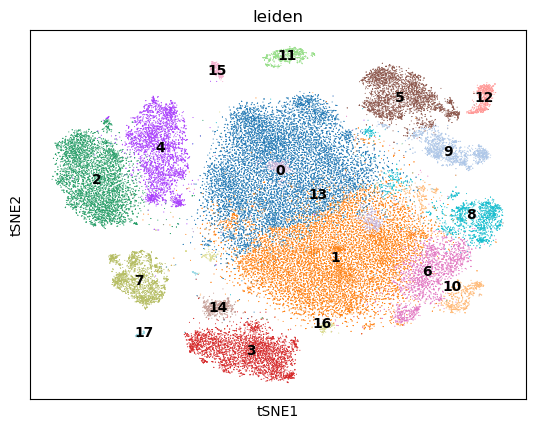

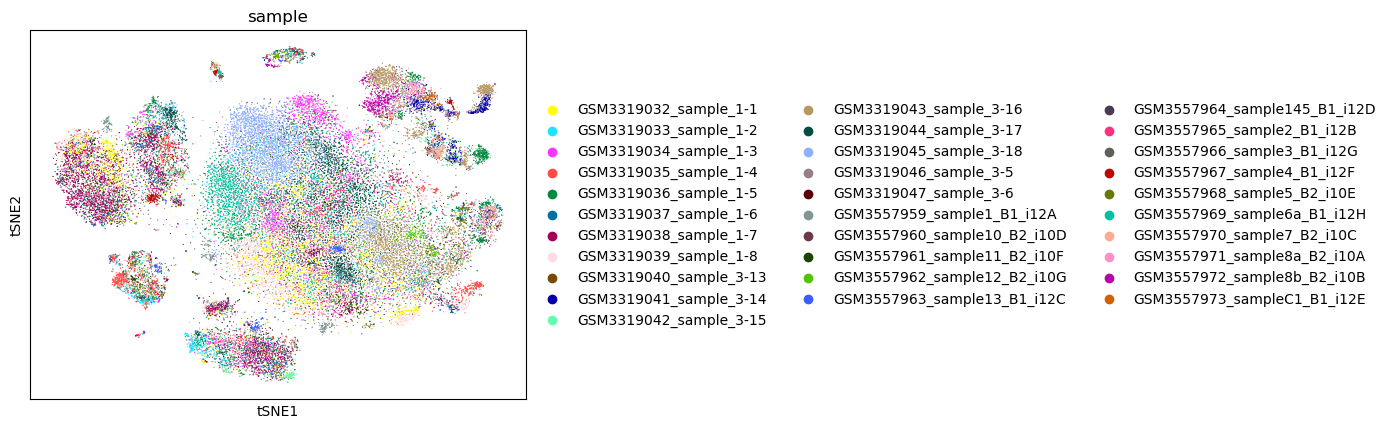

In [31]:
sc.pl.tsne(adata_scvi,color=["leiden"],legend_loc="on data")
sc.pl.tsne(adata_scvi,color=["sample"],legend_loc="right margin")

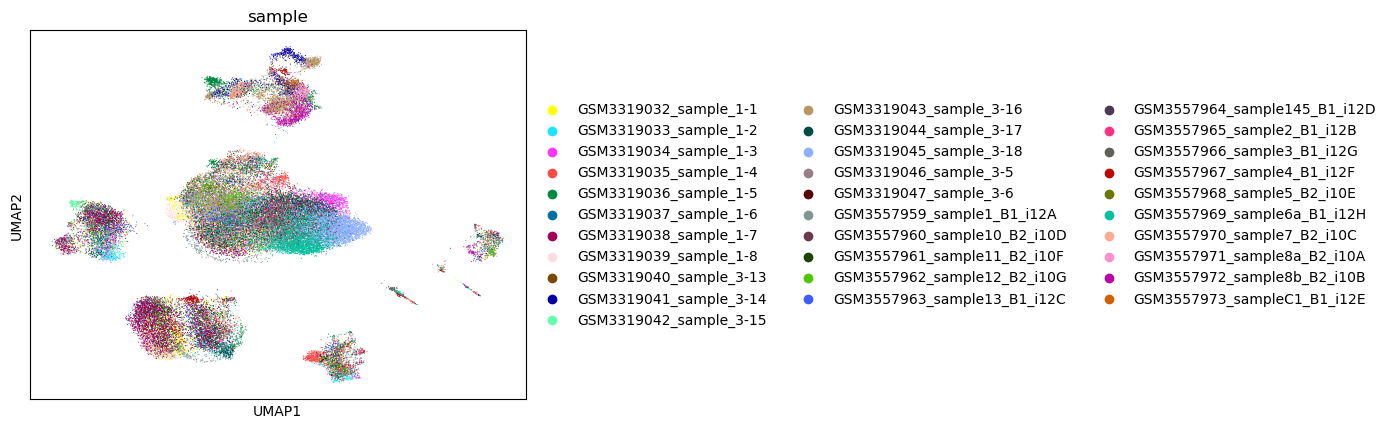

In [22]:
sc.pl.umap(adata_scvi,color=["sample"],wspace = 0.4)

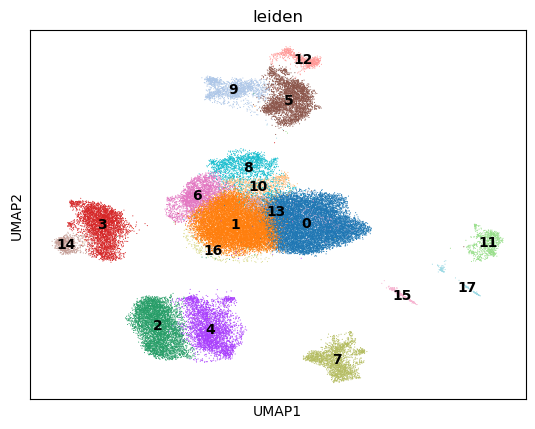

In [33]:
sc.pl.umap(adata_scvi,color=["leiden"],wspace = 0.4, legend_loc="on data")

In [19]:
# import os
# output_path = os.path.join(base_dir,"ovary_scvi_latent_umap_leiden.h5ad")
# adata_scvi.write(output_path,compression = 'gzip')

In [ ]:
# adata_scvi.write("/home/qian@vitra.bio/ava/data/GSE118127/ovary_scvi_latent_umap_leiden.h5ad", compression="gzip")

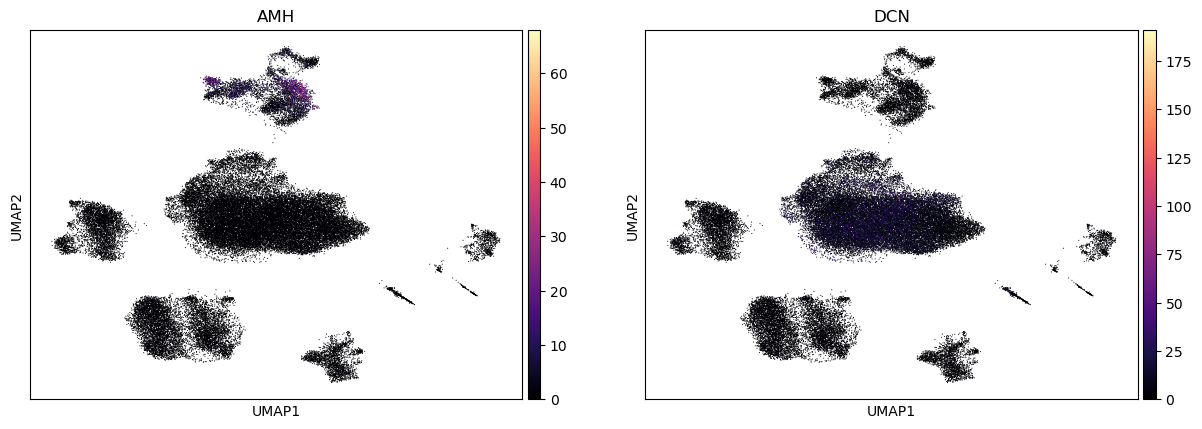

In [34]:
sc.pl.umap(adata_scvi, color=["AMH", "DCN"], layer=None, color_map="magma")

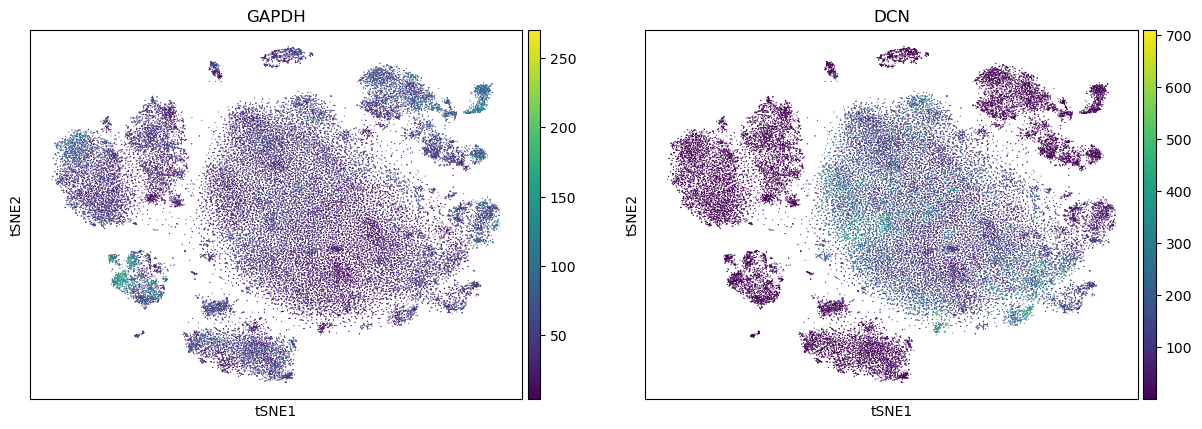

In [35]:
# 
denoised = model.get_normalized_expression(adata_scvi, library_size=1e4)
# 
adata_scvi.layers["scvi_norm"] = denoised.values


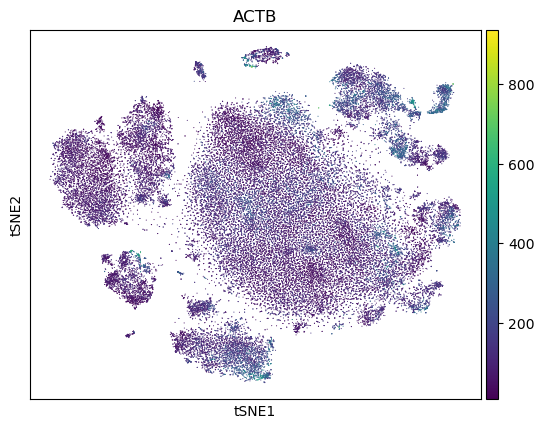

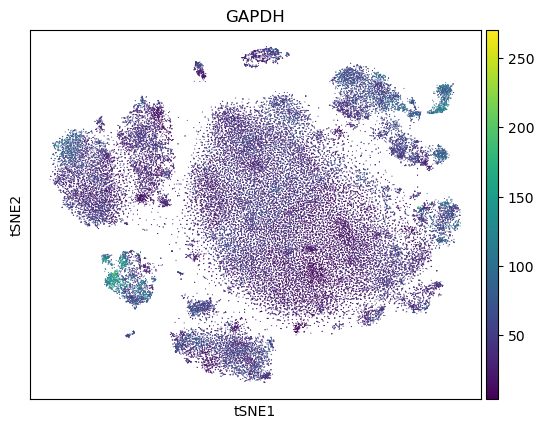

In [38]:
# 
sc.pl.tsne(adata_scvi, color=["ACTB"], layer="scvi_norm")
# 
sc.pl.tsne(adata_scvi, color=["GAPDH"], layer="scvi_norm")

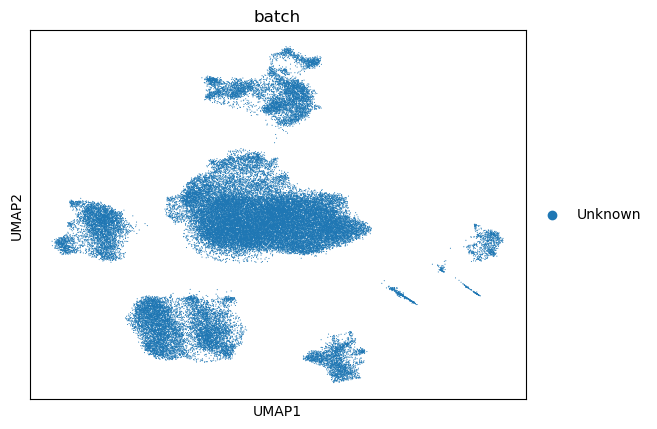

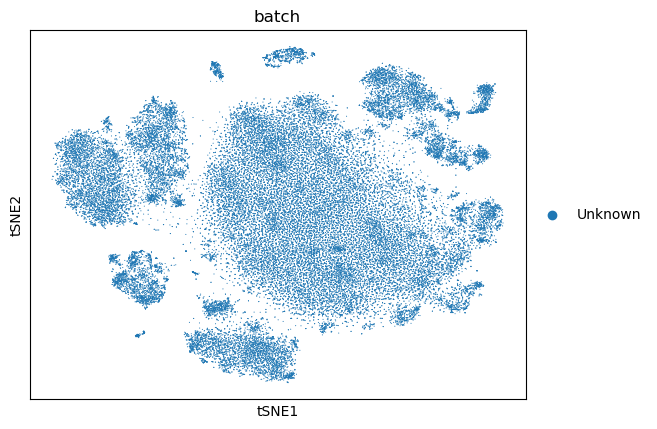

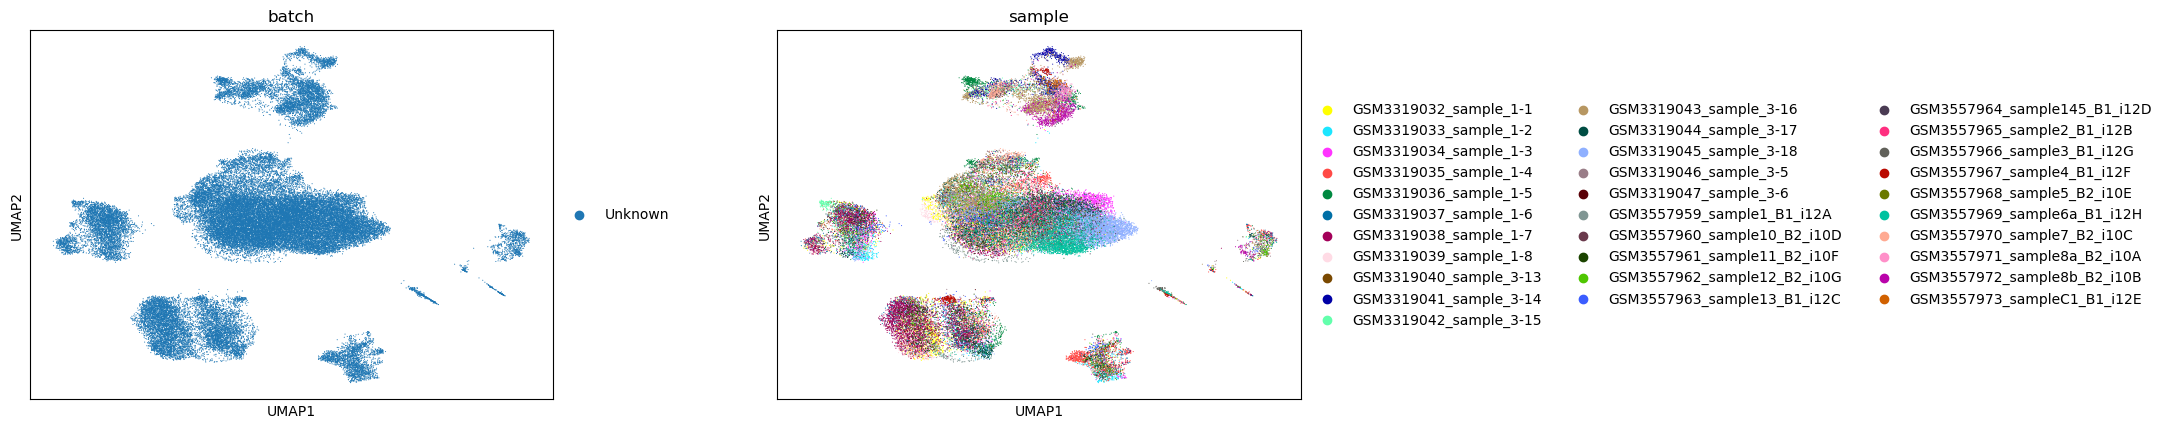

In [24]:
# 1)
BATCH2 = {
    "1-1","1-2","1-3","1-4","1-5","1-6","1-7","1-8",
    "3-5","3-6","3-13","3-14","3-15","3-16","3-17","3-18",
}
BATCH1 = {"6a","8a","8b","145","C1","1","2","3","4","5","7","10","11","12","13"}

def infer_batch(sample_id: str) -> str:
    if sample_id in BATCH2: return "Batch2"
    if sample_id in BATCH1: return "Batch1"
    return "Unknown"

adata_scvi.obs["batch"] = adata_scvi.obs["sample"].astype(str).map(infer_batch).fillna("Unknown")

# UMAP
sc.pl.umap(adata_scvi, color="batch", legend_loc="right margin")
# TSNE
sc.pl.tsne(adata_scvi, color="batch", legend_loc="right margin")

# 3)  batch sample
sc.pl.umap(adata_scvi, color=["batch","sample"], ncols=2, wspace=0.3, legend_loc="right margin")


In [44]:
adata_scvi.obs["sample"]
ref_batch = adata_scvi.obs["sample"].astype("category").cat.categories[0] 
ref_batch

'GSM3319032_sample_1-1'

In [45]:
denoised_ref = model.get_normalized_expression(
    adata_scvi,
    library_size=1e4,
    transform_batch=ref_batch,   # 必须是上面列表里的字符串之一
)
adata_scvi.layers["scvi_ref"] = denoised_ref.values

In [47]:
all_batches = adata_scvi.obs["sample"].astype("category").cat.categories.tolist()
denoised_avg = model.get_normalized_expression(
    adata_scvi,
    library_size=1e4,
    transform_batch=all_batches,   # 列表：对每个批次都解码，再平均
)
adata_scvi.layers["scvi_ref"] = denoised_avg.values


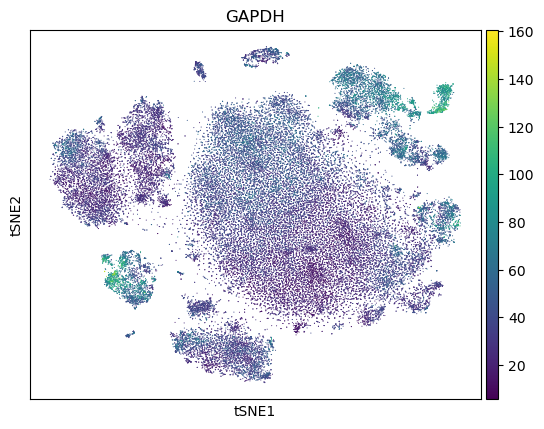

AttributeError: 'ArrayView' object has no attribute 'A'

In [50]:
sc.pl.tsne(adata_scvi, color=["GAPDH"], layer="scvi_ref")

import seaborn as sns, matplotlib.pyplot as plt
df = pd.DataFrame({
    "expr": adata_scvi[:, "AMH"].layers["scvi_ref"].A.flatten(),  
    "sample": adata_scvi.obs["sample"].values
})
plt.figure(figsize=(10,4))
sns.boxplot(x="sample", y="expr", data=df, showfliers=False)
plt.xticks(rotation=90)
plt.ylabel("AMH (scVI ref-normalized)")
plt.show()


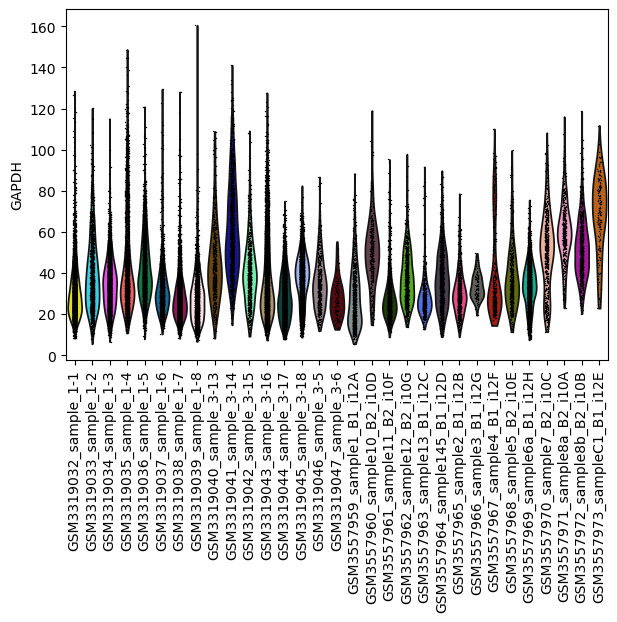

In [57]:
sc.pl.violin(
    adata_scvi,
    keys=["GAPDH"],
    groupby="sample",
    layer="scvi_ref",
    rotation=90
)

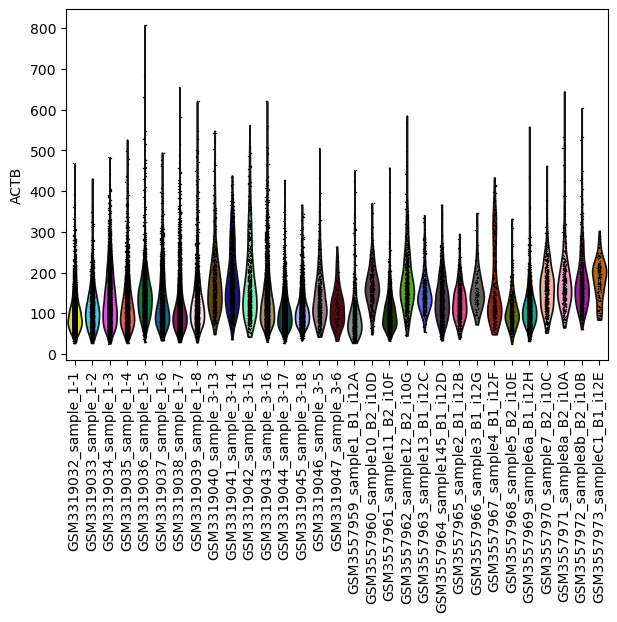

In [56]:
sc.pl.violin(
    adata_scvi,
    keys=["ACTB"],
    groupby="sample",
    layer="scvi_ref",
    rotation=90,
    multi_panel=True
)


# check house keeping gene's expression before batch effect removal

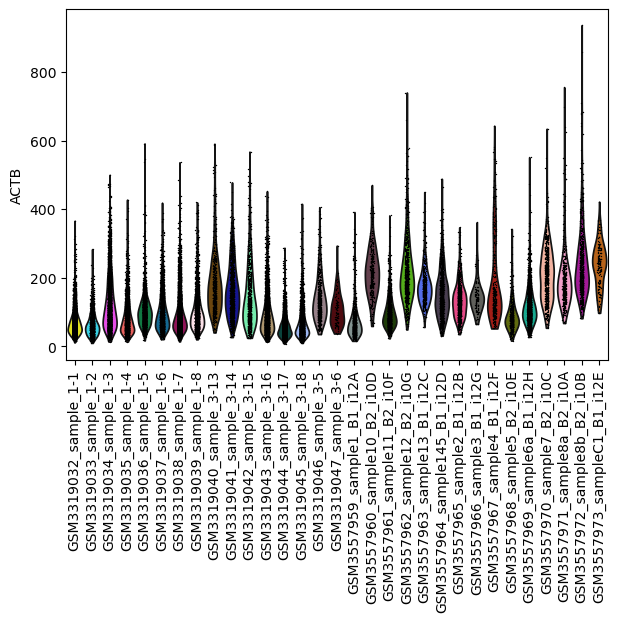

In [61]:
sc.pl.violin(
    adata_scvi,
    keys=["ACTB"],
    groupby="sample",
    layer="scvi_norm",  # 去噪+归一化，但没对齐到同一batch
    rotation=90
)



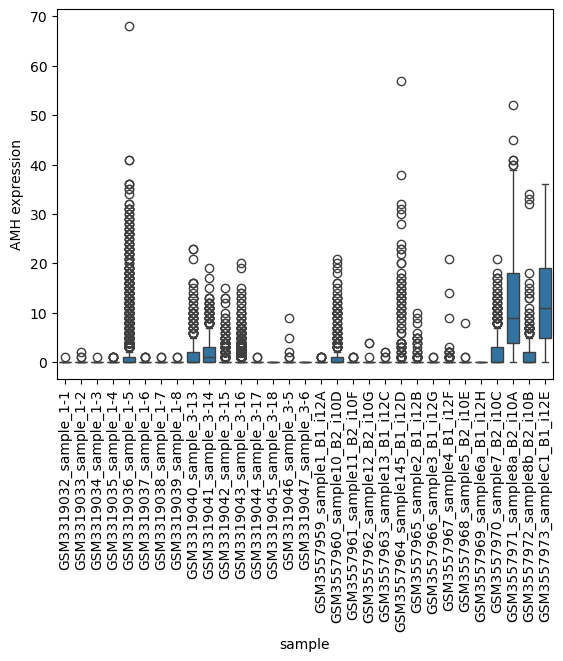

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x="sample", y=adata_all[:, "AMH"].X.toarray().flatten(), data=adata_all.obs)
plt.xticks(rotation=90)
plt.ylabel("AMH expression")
plt.show()


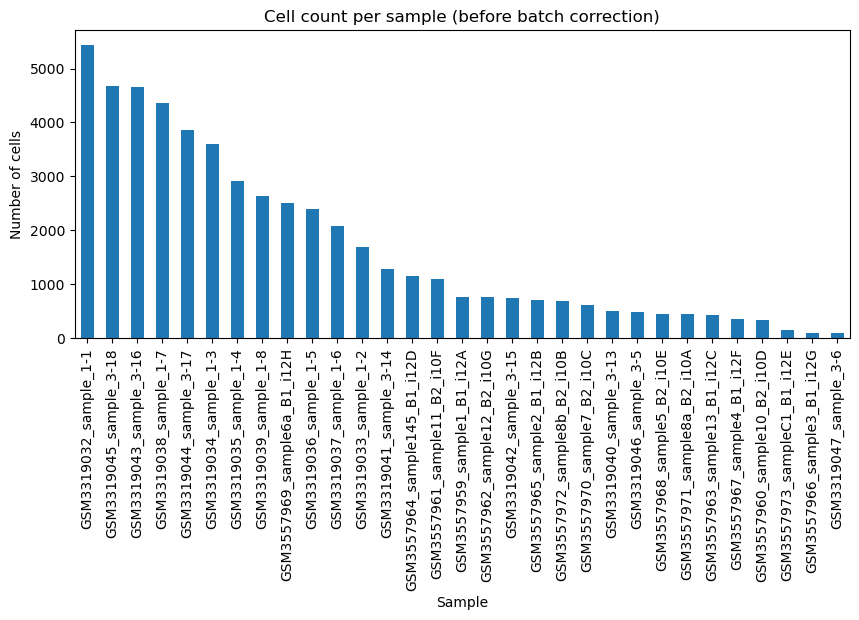

In [28]:
import matplotlib.pyplot as plt

# count # of cell per sample 
cell_counts = adata_all.obs["sample"].value_counts()

# bar plot
plt.figure(figsize=(10,4))
cell_counts.plot(kind="bar")
plt.ylabel("Number of cells")
plt.xlabel("Sample")
plt.title("Cell count per sample (before batch correction)")
plt.show()


In [63]:
de_all = model.differential_expression(
    adata_scvi,
    groupby="leiden",      # 按 cluster 逐一做 vs 其余
    delta=0.5,             # 最小 (log) fold-change 阈值（越大越保守）
    batch_correction=True  # 关键！让 scVI 在统计上边缘化批次，避免 batch 影响
)

DE...: 100%|██████████| 18/18 [08:46<00:00, 29.23s/it]


In [ ]:
adata_

In [64]:
de_all

proba_m1  proba_m2  bayes_factor    scale1    scale2  raw_mean1  \
ARID5B   0.951913  0.048087      2.985471  0.008557  0.001690   3.117139   
GPRC5A   0.949108  0.050892      2.925825  0.001469  0.000283   0.585825   
GLIS3    0.947305  0.052695      2.889103  0.000464  0.000079   0.216147   
SPSB1    0.938690  0.061310      2.728536  0.001180  0.000284   0.376925   
MARCH3   0.936486  0.063514      2.690869  0.000348  0.000071   0.170234   
...           ...       ...           ...       ...       ...        ...   
MT1E     0.028852  0.971148     -3.516302  0.000009  0.000168   0.000000   
RNASE4   0.025847  0.974153     -3.629392  0.000007  0.000238   0.000000   
VIM      0.022040  0.977960     -3.792625  0.003000  0.014647   2.212643   
TSC22D1  0.021639  0.978361     -3.811383  0.000197  0.003247   0.166667   
IFI6     0.014426  0.985574     -4.224194  0.000061  0.001047   0.057471   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
ARID5B    0.946905               0.792579               0.378865   
GPRC5A    0.160252               0.365065               0.114097   
GLIS3     0.058520               0.160523               0.048137   
SPSB1     0.137654               0.262218               0.106279   
MARCH3    0.047057               0.126625               0.041577   
...            ...                    ...                    ...   
MT1E      0.103706               0.000000               0.071037   
RNASE4    0.101137               0.000000               0.083227   
VIM       8.124403               0.695402               0.910127   
TSC22D1   1.629690               0.132184               0.534272   
IFI6      0.664503               0.057471               0.317917   

         raw_normalized_mean1  raw_normalized_mean2  comparison group1 group2  
ARID5B             104.683266             17.311905   0 vs Rest      0   Rest  
GPRC5A              17.142004              2.765167   0 vs Rest      0   Rest  
GLIS3                6.126069              0.998454   0 vs Rest      0   Rest  
SPSB1               10.607485              2.208040   0 vs Rest      0   Rest  
MARCH3               4.822314              0.775941   0 vs Rest      0   Rest  
...                       ...                   ...         ...    ...    ...  
MT1E                 0.000000              2.027464  17 vs Rest     17   Rest  
RNASE4               0.000000              2.474626  17 vs Rest     17   Rest  
VIM                 24.662191            150.341293  17 vs Rest     17   Rest  
TSC22D1              2.729381             32.485634  17 vs Rest     17   Rest  
IFI6                 1.065086             11.250035  17 vs Rest     17   Rest  

[54000 rows x 14 columns]